In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Projects/recommendation/

Mounted at /content/drive
/content/drive/My Drive/Projects/recommendation


In [2]:
from dataset.dataset import SparseMatrixDataset
from models.ultragcn import UltraGCN_matrix
from models.ngcf import NGCF_matrix
from models.lgcn import LGCN_matrix
from torch.utils.data import DataLoader
from torch import optim
from tqdm.auto import tqdm

In [3]:
class config:
    user_path= "data/gowalla/user_list.txt"
    item_path= "data/gowalla/item_list.txt"
    edge_path= "data/gowalla/train.txt"

In [4]:
dataset = SparseMatrixDataset(config)

In [5]:
class config2:
    user_num= dataset.user_num
    item_num= dataset.item_num
    hidden_size = 64
    layers_num = 3


In [6]:
model = UltraGCN_matrix(config2)

In [7]:
train_dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)


In [8]:
model.train()
optimizer = optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)


In [9]:
# L_matrix = dataset.get_laplacian_matrix()
# I_matrix = dataset.get_identity_matrix()
converge = dataset.get_converge_matrix()
wm, sm = dataset.get_weight_adj_matrix(10)

print(wm.size(), sm.size())
device = 'cuda:0'

torch.Size([40981, 10]) torch.Size([40981, 10])


In [10]:
losses = []
model.to(device)
# L_matrix= L_matrix.to(device)
# I_matrix=I_matrix.to(device)
wm, sm = wm.to(device), sm.to(device)
converge = converge.to(device)

for user, pos, neg in tqdm(train_dataloader, desc="train process"):
    pos_beta, neg_beta = model.get_data_from_sparse(converge, user, pos, neg)
    user, pos, neg = user.to(device), pos.to(device), neg.to(device)
    pos_beta, neg_beta = pos_beta.to(device), neg_beta.to(device)
    optimizer.zero_grad()
    loss = model(user, pos, neg, pos_beta, neg_beta, wm, sm)
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().cpu().item())


train process:   0%|          | 0/792 [00:00<?, ?it/s]

In [13]:

for user, pos, neg in tqdm(train_dataloader, desc="train process"):
    pos_beta, neg_beta = model.get_data_from_sparse(converge, user, pos, neg)
    user, pos, neg = user.to(device), pos.to(device), neg.to(device)
    pos_beta, neg_beta = pos_beta.to(device), neg_beta.to(device)
    optimizer.zero_grad()
    loss = model(user, pos, neg, pos_beta, neg_beta, wm, sm)
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().cpu().item())

train process:   0%|          | 0/792 [00:00<?, ?it/s]

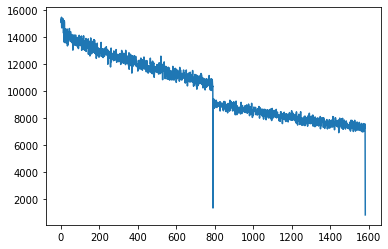

In [14]:
from matplotlib import pyplot as plt

%matplotlib inline
plt.plot(losses)
plt.show()